In [12]:
import pyspark
import pandas as pd
import json
import folium
import numpy as np
import vincent
vincent.core.initialize_notebook()
from vincent import AxisProperties, PropertySet, ValueRef
from pyspark.sql import SQLContext
sqlContext1 = SQLContext(sc)
from IPython.display import Image

#### Instagrams per canton

In [2]:
by_canton = sqlContext1.read.parquet("py_for_cluster/viz/insta_by_canton.parquet").toPandas()
cantons= by_canton.sort_values(by='count').set_index('canton')
cantons['count']=np.log(cantons['count'])

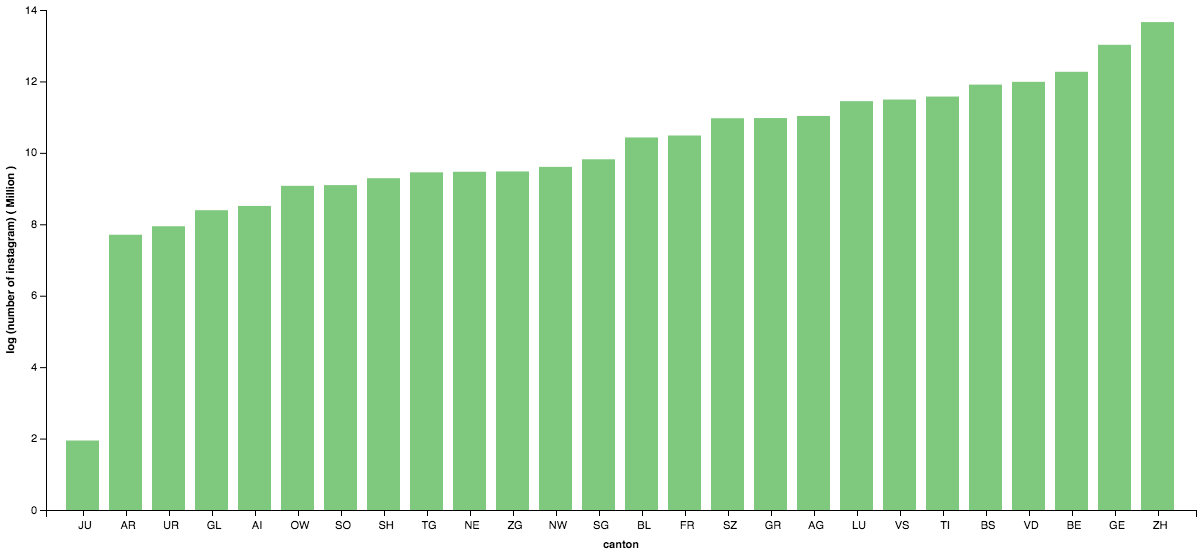

In [13]:
group = vincent.GroupedBar(cantons)
group.colors(brew='Accent')
group.axis_titles(x='canton', y='log (number of instagram) ( Million )')
group.width=1150
group
Image('pic/insta_per_canton.png', width=1050,height=250)

#### sentiment analysis results

In [4]:
vis1 = sqlContext1.read.parquet("py_for_cluster/viz/total_sent.parquet").toPandas()

In [5]:
vis_1= dict()
vis_1['Negative']=int(vis1.set_index('label').loc[2.0][0])
vis_1['Neutral']=int(vis1.set_index('label').loc[1.0][0])
vis_1['Positive']=int(vis1.set_index('label').loc[0.0][0])

In [6]:
pies = vincent.Pie(vis_1,width=1160)
pies.legend('sentiment')
pies.to_json('bar.json')

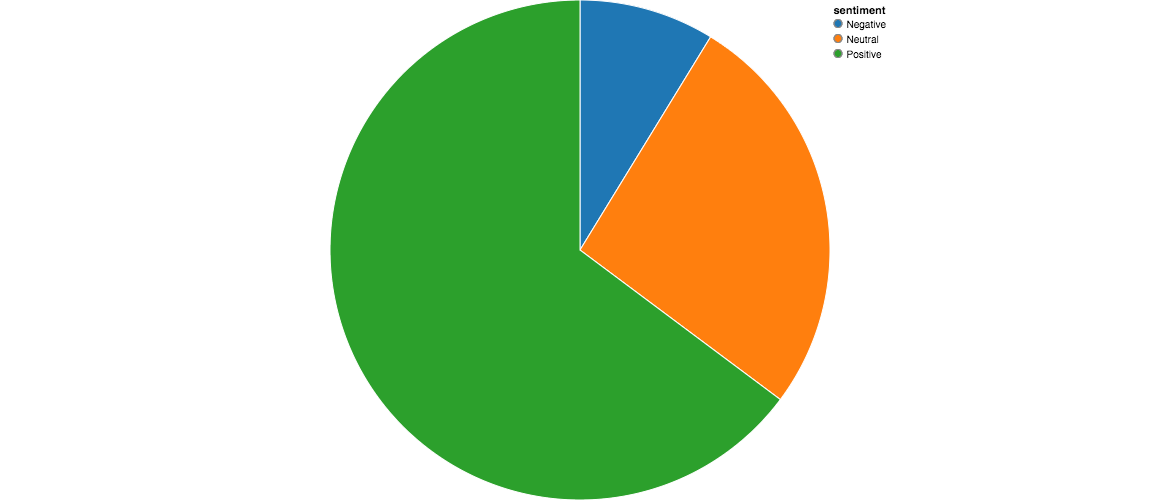

In [14]:
Image('pic/pos-neg.png', width=1050,height=250)

#### Number of insta per month

In [8]:
vis2 = sqlContext1.read.parquet("py_for_cluster/viz/total_sent_per_month.parquet").toPandas()

In [9]:
vis2.ix[0,0]='sad'
vis2.ix[1,0]='neutral'
vis2.ix[2,0]='happy'
vis3 = vis2[['label_date_found','01','02','03','04', '05','06','07', '08', '09', '10']]
vis_2=vis3.set_index('label_date_found')
month_index = ['january','february','march','april', 'may','june','july', 'august','september','october']
vis_2.columns = month_index
vis_2_score= vis_2.copy()
totals = []
for i in vis_2.columns:
    totals.append(np.sum(vis_2[i])/1000000)
    vis_2_score[i]=vis_2[i]/np.sum(vis_2[i])
tot = pd.DataFrame(index=month_index) 
tot['totals']=totals

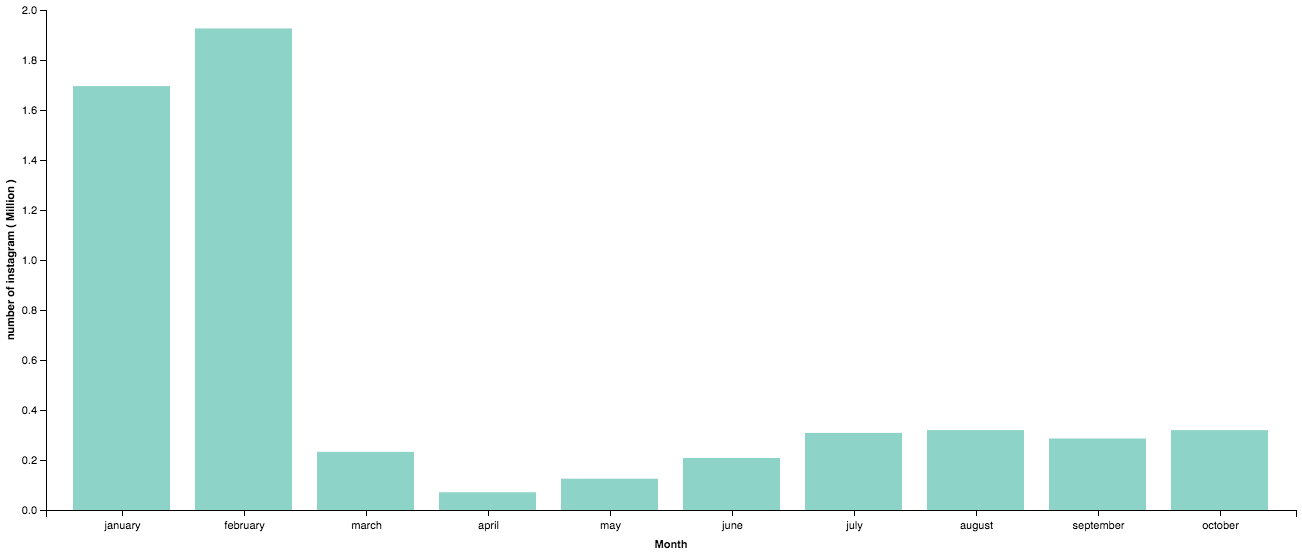

In [15]:
group = vincent.GroupedBar(tot)
group.colors(brew='Set3')
group.axis_titles(x='Month', y='number of instagram ( Million )')
group.width=1250
Image('pic/insta_per_month.png', width=1050,height=250)

#### sentiment analysis per month

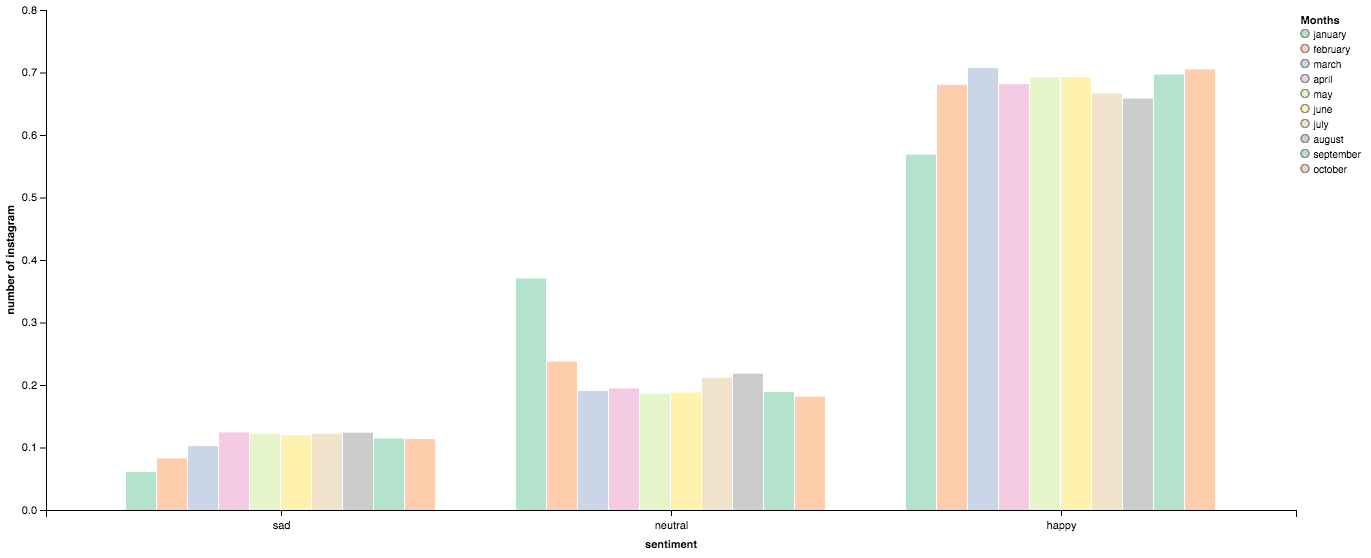

In [17]:
group = vincent.GroupedBar(vis_2_score)
group.legend(title='Months')
group.colors(brew='Pastel2')
group.axis_titles(x='sentiment', y='number of instagram')
group.width=1250
Image('pic/sent_per_month.png', width=1050,height=250)

#### Tag study

In [10]:
postags = sqlContext1.read.parquet('py_for_cluster/viz/tags_per_sent_0.parquet').toPandas()
negtags = sqlContext1.read.parquet('py_for_cluster/viz/tags_per_sent_2.parquet').toPandas()

In [63]:
postags.head(10)

,_1,_2
0,switzerland,1905994
1,swiss,501698
2,love,500192
3,italy,439182
4,follow,432491
5,france,404799
6,instagood,402820
7,zurich,394632
8,germany,391983
9,netherlands,379518


In [64]:
negtags.head(10)

,_1,_2
0,switzerland,218491
1,swiss,82068
2,follow,79117
3,justinbieber,69620
4,clashofclans,69321
5,supercell,69301
6,coc,69295
7,cocon,69263
8,clashon,69258
9,clashofclan,69239


# First Map: happy instamap

#### markers for the choropleth map

In [ ]:
canton_locations=[['Aargau',47.3876664,8.255429499999991],['Appenzell Rhodes-Intérieures ',47.18,9.24],['Appenzell Rhodes-Extérieures ',47.03,9.01],['Bern',46.9479739,7.4474467999999],
                  ['Bâle-Campagne',47.44181220000001,7.764400199999955],['Bâle Ville',47.55959860000001,7.588576099999955],['Fribourg',46.72, 7.09],
                  ['Genève',46.18, 6.13],['Glaris',47.04112319999999,9.067900000000009],['Grison',46.65698709999999,9.578025700000012],
                  ['Jura',47.4,7.0833],['Lucern',47.050168199999,8.3093072000000],['Neuchatel',46.9899874,6.9292732000000],
                  ['Nidwald',46.9267016,8.384998],['Obwald',46.877858,8.25124900],['Saint-Gall',47.4244818,9.376717296],['Schaffhouse',47.43,8.34],
                  ['Soleure',47.2088348,7.5322909999999],['Schwytz',47.0723828,8.79036480000],['Turgau',47.60378559999,9.0557370999999],
                  ['Ticino',46.331734,8.800452899999982], ['Uri',46.7738629,8.60251530000005],['Vaud',46.5, 6.62],['Valais',46.04,7.36],
                  ['Zoug',47.1497017,8.547771499999953], ['Zurich',47.3768866,8.541694000000007]
                 ]

In [120]:
vis_marker0 = sqlContext1.read.parquet("py_for_cluster/viz/per_canton_month_0.parquet").toPandas()[['canton_date_found','01','02','03','04', '05', '06', '07', '08', '09', '10']]
vis_marker1 = sqlContext1.read.parquet("py_for_cluster/viz/per_canton_month_1.parquet").toPandas()[['canton_date_found','01','02','03','04', '05', '06', '07', '08', '09', '10']]
vis_marker2 = sqlContext1.read.parquet("py_for_cluster/viz/per_canton_month_2.parquet").toPandas()[['canton_date_found','01','02','03','04', '05', '06', '07', '08', '09', '10']]
vis_marker2.loc[-1]=[' JU',0,0,0,0,0,0,0,0,0,0]
vis_marker_0=vis_marker0.set_index('canton_date_found').sort_index()
vis_marker_1=vis_marker1.set_index('canton_date_found').sort_index()
vis_marker_2=vis_marker2.set_index('canton_date_found').sort_index()
stacks = []
for i in range(vis_marker0.shape[0]):
    kant=vis_marker_0.index[i]
    listeu0 =vis_marker_0.ix[i,:].tolist()
    listeu1 =vis_marker_1.ix[i,:].tolist()
    listeu2 =vis_marker_2.ix[i,:].tolist()
    
    month_index = ['january','february','march','april', 'may','june','july', 'august','september','october']
    df_chart = pd.DataFrame(index=month_index) 
    df_chart['happy']=listeu0
    df_chart['neutral']=listeu1
    df_chart['sad']=listeu2
    #print(df_chart)
    df_chart_copy=df_chart.copy()
    for j in df_chart.index:
        if(np.sum(df_chart.loc[j])!=0):
            df_chart_copy.loc[j]=df_chart.loc[j]/np.sum(df_chart.loc[j])
    #print(df_chart_copy) 
    stack = vincent.StackedBar(df_chart_copy, width=450, height=150)
    stack.axis_titles(x='months', y='number of insta')
    stack.scales['x'].padding = 0.2
    #stack.width
    stack.colors(brew='Pastel1')
    stack.legend(title='Canton: '+canton_locations[i][0])
    stacks.append(stack)

#### scores for the choropleth map

In [37]:
vis_canton = sqlContext1.read.parquet("py_for_cluster/viz/insta_map_scores.parquet").toPandas()
vis_canton['score'] = vis_canton['happy']/vis_canton['total']*0.7 + vis_canton['neutral']/vis_canton['total']*0.3
for i in range(vis_canton.shape[0]):
    vis_canton.ix[i,0]=vis_canton.ix[i,0][1:]
# find locations for each cantons...

In [121]:
# Let Folium determine the scale.
canton_topo = r'ch-cantons.topojson.json'
m = folium.Map(location=[46.55, 6.76], zoom_start=7)
m.choropleth(geo_path=canton_topo,
            data=vis_canton[['canton','score']],
            columns=['canton', 'score'],
            key_on='feature.id',
            threshold_scale=[0.35,0.5,0.53,0.54,0.55,0.56],
            fill_color='PuBu', line_opacity=1,
            
            fill_opacity=0.8,
            legend_name='Sentiment score',
             topojson='objects.cantons')
marker_cluster = folium.MarkerCluster("stats per canton cluster").add_to(m)
j=0
for i in canton_locations:
    popup = folium.Popup(max_width=3800)
    folium.Vega(stacks[j], height=250, width=600).add_to(popup)
    folium.CircleMarker(canton_locations[j][1:],radius=12,popup=popup,color='black',fill_opacity=0.8,fill_color='grey').add_to(marker_cluster)
    j=j+1

In [123]:
m

In [124]:
m.save("./canton_sentiments.html")

# Second map: density of instagrams

In [14]:
loc_cities=[
    ['Lausanne', 46.5333, 6.6667],
    ['Genève', 46.2, 6.1667],
    ['Lucerne', 47.0833, 8.2667],
    ['Lugano', 46.0058, 8.9475],
    ['St. Gallen', 47.4667, 9.4],
    ['Neuchâtel', 47, 6.9667],
    ['Zürich', 47.3667, 8.55],
    ['St. Moritz', 46.5083, 9.8833],
    ['Yverdon-les-Bains', 46.7833, 6.65],
    ['Sion',46.2333, 7.35]
        ]

In [15]:
vis_city = sqlContext1.read.parquet("py_for_cluster/viz/insta_density.parquet").toPandas()
geo_path= 'admin_level_8.geojson'
m = folium.Map(location=[46.5, 8], zoom_start=7)
m.choropleth(geo_path=geo_path,
            data=vis_city,
            columns=['city', 'count'],
            key_on='feature.properties.swisstopo:BFS_NUMMER',
            threshold_scale=[0,30,60,90],
            fill_color='YlGnBu',
            fill_opacity=0.7,
            line_opacity=1,
            legend_name='number of InstaPost')
for i in loc_cities:
    
    folium.RegularPolygonMarker(location = i[1:], popup = i[0],fill_color='black', number_of_sides=8, radius=6).add_to(m)



In [16]:
m.save("./city_density.html")